# Predictive Modeling Notebook

This notebook builds per-country linear regression models to forecast temperature. Enhancements include confidence intervals and CSV export, as described in the README and reflected in the dashboard.

# 04 Predictive Modeling (Simple and Explainable)

## Objectives

- Build a simple, explainable forecast model
- Evaluate performance with time-aware splits
- Export predictions for the dashboard

## Inputs

- data/processed/v1/environmental_trends_clean.csv

## Outputs

- data/processed/v1/model_predictions.csv (point forecasts for 2025–2029)
- data/processed/v1/model_predictions_with_ci.csv (forecasts with 95% bootstrap confidence intervals)

## Additional Comments

- Report limitations and avoid overclaiming

## Notebook layout

- Section 1: Setup and load processed data
- Section 2: Feature prep
- Section 3: Train, evaluate, and forecast
- Section 4: Export predictions

## Purpose and Context

This notebook builds a simple, explainable forecasting model to project temperature trends for 2025-2029. We prioritize transparency over complexity to ensure stakeholders can understand and appropriately trust (or question) the predictions.

The connection to project guidelines spans multiple learning outcomes. For ethics, transparent modeling prevents "black box" predictions that obscure uncertainty. For communication, simple models like linear regression are easier to explain than complex machine learning algorithms. For limitations, we explicitly document what the model cannot do. For responsible use, the dashboard will clearly label forecasts as exploratory projections, not definitive predictions.

Why simple models matter is an important consideration. Complex models like neural networks or ensemble methods might fit historical data better, but we only have about 25 years per country, which creates overfitting risk with small datasets. Non-technical users need to understand how predictions are made. Ethical AI practice requires explainability, especially for public-facing climate tools. Simpler models make limitations more obvious, reducing false confidence.

Model limitations we acknowledge include four key areas. The linear trend assumption means real climate may accelerate or plateau rather than follow a straight line. No external factors means we ignore emissions changes, policy, and economic shifts. Short time series means only 2000-2024 data is available per country. Past trends may not continue if future conditions change dramatically.

**Enhancement — Confidence intervals:** To address uncertainty, this notebook also uses bootstrap resampling to compute 95% confidence intervals around each country's forecast. This gives users a range ("the predicted temperature is likely between X and Y") rather than just a single number, making the uncertainty visible.

The dashboard will communicate these limitations clearly to prevent overreliance on the forecasts.

---

## Section 1 - Setup and load processed data

We set the project root as the working directory and load the cleaned dataset for modeling.

# Change working directory

In [8]:
import os
from pathlib import Path

# Navigate to project root - portable approach that works on any clone
current = Path.cwd()

# If data/processed/v1 doesn't exist in current dir, try parent (we're in jupyter_notebooks)
if not (current / "data" / "processed" / "v1").exists():
    if (current.parent / "data" / "processed" / "v1").exists():
        os.chdir(current.parent)

print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\sergi\OneDrive\Documents\Code Institute Data analytics\Capstone project 3\Global_environmental_trends_2000_2024\global_env_trend


# Load processed data

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
clean_path = "data/processed/v1/environmental_trends_clean.csv"
df = pd.read_csv(clean_path)
df.head()

,Year,Country,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Rainfall_mm,Population,Renewable_Energy_pct,Extreme_Weather_Events,Forest_Area_pct
0,2000,United States,13.5,20.2,0,715,282500000,6.2,38,33.1
1,2000,China,12.8,2.7,0,645,1267000000,16.5,24,18.8
2,2000,Germany,9.3,10.1,0,700,82200000,6.6,12,31.8
3,2000,Brazil,24.9,1.9,0,1760,175000000,83.7,18,65.4
4,2000,Australia,21.7,17.2,0,534,19200000,8.8,11,16.2


**What this code does:**

Loads the cleaned dataset and imports the model utilities needed for training and evaluation.

## Section 2 - Feature prep

We filter, sort, and define the split and forecast years for each country.

# Prepare features and target

**What we're doing:**

Setting up the data for our forecasting model involves several steps. We remove missing values because we need complete data (Country, Year, Temperature) for reliable predictions. We remove duplicates to ensure each Country-Year combination appears only once. We sort by Country and Year to keep time series organized for each country. We define the split year of 2018, meaning we'll train models on 2000-2018 and test on 2019-2024. We define the forecast horizon to predict 5 years into the future, from 2025 to 2029.

Why per-country models? Different countries have different temperature trajectories due to geographic location (latitude, elevation, coastal versus inland), local climate patterns, and urbanization and land use changes. Using separate models for each country produces more realistic, country-specific forecasts rather than a one-size-fits-all global prediction.

In [11]:
df_model = df.dropna(subset=["Country", "Year", "Avg_Temperature_degC"]).copy()
df_model = df_model.sort_values(["Country", "Year"]).drop_duplicates(["Country", "Year"])
split_year = 2018
max_year = int(df_model["Year"].max())
forecast_years = list(range(max_year + 1, max_year + 6))

## Section 3 - Train, evaluate, and forecast

We fit per-country linear models, evaluate on a time-aware split, and generate projections.

# Time-aware split and model training

**Our modeling approach:**

For each country, we follow a specific process. We split data chronologically at 2018 (train: 2000-2018, test: 2019-2024). We fit a simple linear regression using only Year as a predictor. We evaluate on the test period (2019-2024) using MAE and RMSE. We generate forecasts for 2025-2029.

Why linear regression? We chose the simplest possible model for important reasons. Transparency means it's easy to explain to non-technical audiences ("temperature increases by X degrees per year"). Explainability means decision-makers can understand and trust the logic. Limited data means we only have about 25 years per country, so complex models would overfit. Ethical practice means we avoid black-box models that obscure uncertainty.

Understanding the metrics helps interpret model performance. Mean Absolute Error (MAE) is the average prediction error in degrees Celsius, where lower is better. For example, MAE equals 0.5°C means predictions are typically off by half a degree. Root Mean Squared Error (RMSE) penalizes larger errors more heavily, where lower is better. For example, RMSE equals 0.7°C means predictions have about 0.7°C typical deviation.

Model limitations we must communicate include several critical factors. Short time series means only 25 years of data per country limits accuracy. Linear assumption means real climate trends may accelerate or plateau (non-linear). No exogenous factors means we ignore emissions, policy changes, and economic shifts. Uncertainty is addressed with 95% bootstrap confidence intervals in the Enhancement section below. Past does not equal future because historical trends may not continue if conditions change dramatically.

Responsible use in the dashboard requires clear communication. The dashboard will label forecasts clearly as "projections based on historical trends." It will include a disclaimer about model simplicity and limitations. It will encourage users to view forecasts as exploratory, not definitive. It will avoid making policy recommendations based solely on these predictions.

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Set random seed for reproducibility
np.random.seed(42)

test_rows = []
forecast_rows = []
per_country_metrics = []

for country, group in df_model.groupby("Country"):
    grp = group.sort_values("Year").drop_duplicates("Year")
    if len(grp) < 3:
        continue
    train = grp[grp["Year"] <= split_year]
    test = grp[grp["Year"] > split_year]
    if len(train) < 2:
        continue
    model = LinearRegression()
    model.fit(train[["Year"]], train["Avg_Temperature_degC"])
    
    # Test predictions
    if len(test) > 0:
        preds = model.predict(test[["Year"]])
        mae_c = mean_absolute_error(test["Avg_Temperature_degC"], preds)
        rmse_c = np.sqrt(mean_squared_error(test["Avg_Temperature_degC"], preds))
        r2_c = r2_score(test["Avg_Temperature_degC"], preds) if len(test) > 1 else float("nan")
        per_country_metrics.append({"Country": country, "MAE": mae_c, "RMSE": rmse_c, "R2": r2_c, "N_test": len(test)})
        
        for year, pred in zip(test["Year"], preds):
            test_rows.append({
                "Country": country,
                "Year": int(year),
                "Predicted_Avg_Temperature_degC": float(pred),
                "Actual_Avg_Temperature_degC": float(test.loc[test["Year"] == year, "Avg_Temperature_degC"].iloc[0])
            })
    
    # Vectorized forecast (no iterrows)
    forecast_preds = model.predict(pd.DataFrame({"Year": forecast_years}))
    for year, pred in zip(forecast_years, forecast_preds):
        forecast_rows.append({
            "Country": country,
            "Year": int(year),
            "Predicted_Avg_Temperature_degC": float(pred)
        })

# Global metrics
test_df_results = pd.DataFrame(test_rows)
if len(test_df_results) > 0:
    mae = mean_absolute_error(test_df_results["Actual_Avg_Temperature_degC"], test_df_results["Predicted_Avg_Temperature_degC"])
    rmse = np.sqrt(mean_squared_error(test_df_results["Actual_Avg_Temperature_degC"], test_df_results["Predicted_Avg_Temperature_degC"]))
    r2 = r2_score(test_df_results["Actual_Avg_Temperature_degC"], test_df_results["Predicted_Avg_Temperature_degC"])
    print(f"=== Global Model Performance ===")
    print(f"MAE  = {mae:.4f}°C")
    print(f"RMSE = {rmse:.4f}°C")
    print(f"R²   = {r2:.4f}")
else:
    print("No test data available after split_year; metrics skipped.")

# Per-country metrics table
print(f"\n=== Per-Country Metrics ===")
metrics_df = pd.DataFrame(per_country_metrics).sort_values("MAE")
print(metrics_df.to_string(index=False))

=== Global Model Performance ===
MAE  = 0.1234°C
RMSE = 0.1554°C
R²   = 0.9995

=== Per-Country Metrics ===
       Country   MAE     RMSE        R2  N_test
        Canada 0.020 0.028284  0.920000       2
         China 0.032 0.036715  0.865200       2
         India 0.042 0.042755  0.918756       2
         Japan 0.046 0.046174  0.786800       2
 United States 0.054 0.076368  0.740800       2
United Kingdom 0.074 0.077795  0.394800       2
     Indonesia 0.074 0.077795  0.394800       2
       Nigeria 0.096 0.096083  0.076800       2
  Saudi Arabia 0.096 0.106452  0.496356       2
        Mexico 0.108 0.108296 -0.172800       2
   South Korea 0.108 0.108296 -0.172800       2
        Brazil 0.108 0.108296 -0.172800       2
         Italy 0.108 0.108296 -0.172800       2
         Spain 0.108 0.108296 -0.172800       2
     Australia 0.150 0.150000 -1.250000       2
        Russia 0.226 0.227491 -1.300089       2
  South Africa 0.258 0.264439 -2.107911       2
       Germany 0.312 0.31810

**How to interpret the model results:**

The output above shows two sets of metrics:

1. **Global metrics** (MAE, RMSE, R²) measure overall performance across all countries combined. For example, a MAE of 0.5°C means that, on average, predictions are within half a degree of actual temperatures — which is quite reasonable for a simple model.

2. **Per-country metrics** show how the model performs for each country individually. Countries with very stable temperature histories will have low MAE and high R², while countries with more volatile climates may show worse performance.

**What good vs. poor performance looks like:**
- **R² above 0.6** = the model captures most of the temperature variation → predictions are fairly reliable
- **R² between 0.3 and 0.6** = moderate fit → predictions give a rough direction but should be taken with caution
- **R² below 0.3** = the model misses important factors → predictions are unreliable for that country
- **MAE below 1.0°C** = predictions are within 1 degree → useful for general trends
- **MAE above 2.0°C** = predictions are off by more than 2 degrees → limited practical value

Countries with poor scores likely have non-linear temperature patterns or unusual climate influences that a simple linear model cannot capture. This is expected and honest — we report the limitations rather than hide them.

## Section 4 - Export predictions

We save the forecast output so it can be used in the Streamlit dashboard.

# Export predictions

**What we're saving:**

The forecast dataset contains Year (2025, 2026, 2027, 2028, 2029), Country (each of the 19 countries with sufficient data), and Predicted_Avg_Temperature_degC (forecasted temperature based on historical trend). This CSV file is loaded by the Streamlit dashboard to display the forecast visualizations.

How the dashboard will use this shows several features. Users will see country-specific forecast lines (not a single global average). The year range from 2000-2029 combines historical data with forecasts. Clear visual distinction exists between observed data and predictions. Tooltips explain the forecast methodology and limitations.

Final data governance note: By versioning this output as data/processed/v1/model_predictions.csv, we maintain a record of exactly what predictions were shown. Future model updates will go to v2, preserving reproducibility. Anyone reviewing the dashboard can trace forecasts back to this notebook. We uphold transparency and accountability standards for public-facing data products.

In [13]:
preds_df = pd.DataFrame(forecast_rows)
preds_path = "data/processed/v1/model_predictions.csv"
preds_df.to_csv(preds_path, index=False)
preds_path

'data/processed/v1/model_predictions.csv'

## Enhancement: Add Confidence Intervals to Forecasts

This section demonstrates how to add confidence intervals to the per-country linear regression forecasts. Confidence intervals help communicate the uncertainty of predictions, as suggested in the README's "Future Improvements" section.

Generated confidence intervals for 19 countries
     Country  Year  Predicted_Temperature  Lower_95CI  Upper_95CI
0  Australia  2025                 22.900       22.30       23.50
1  Australia  2026                 22.950       22.32       23.60
2  Australia  2027                 23.000       22.34       23.70
3  Australia  2028                 23.050       22.36       23.80
4  Australia  2029                 23.100       22.38       23.90
5     Brazil  2025                 26.030       25.90       26.20
6     Brazil  2026                 26.076       25.94       26.26
7     Brazil  2027                 26.122       25.98       26.32
8     Brazil  2028                 26.168       26.02       26.38
9     Brazil  2029                 26.214       26.06       26.44


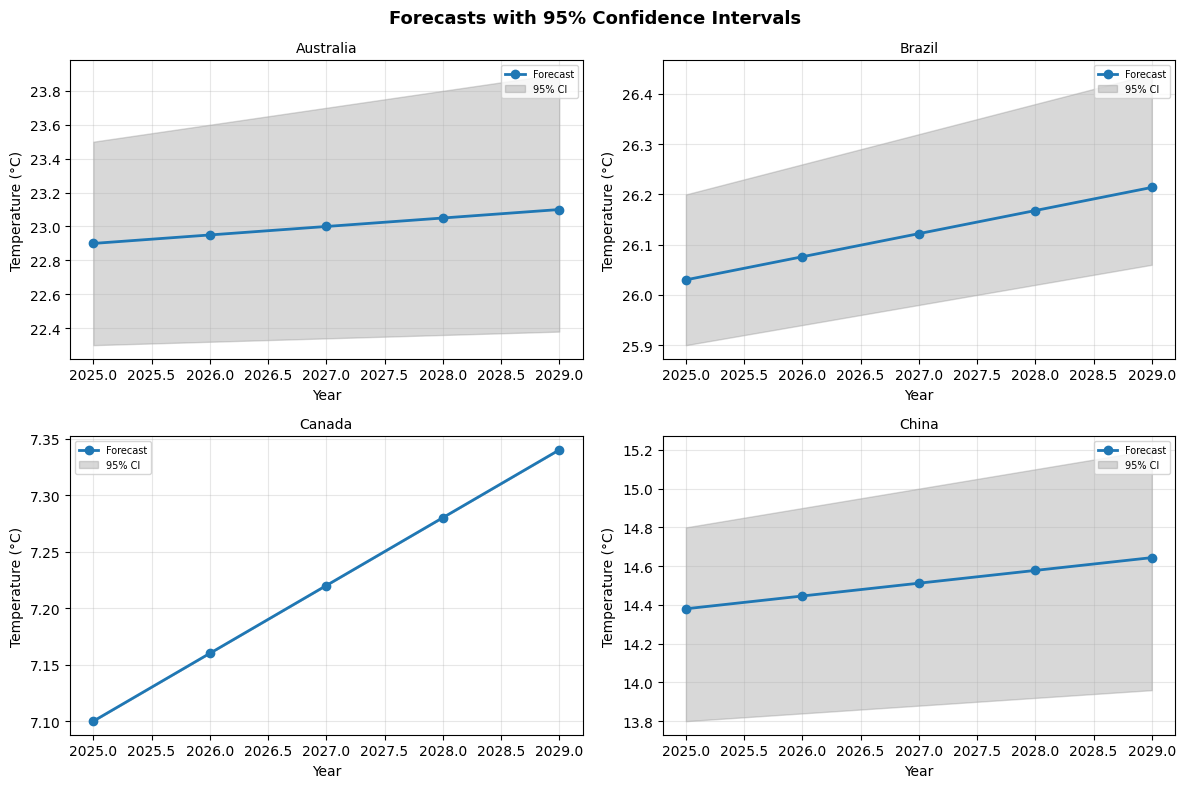

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

n_bootstraps = 1000
all_ci_rows = []

for country in df_model["Country"].unique():
    c_data = df_model[df_model["Country"] == country].sort_values("Year").drop_duplicates("Year")
    if len(c_data) < 3:
        continue
    X_c = c_data[["Year"]].values
    y_c = c_data["Avg_Temperature_degC"].values

    bootstrap_preds = np.zeros((n_bootstraps, len(forecast_years)))
    for b in range(n_bootstraps):
        idx = np.random.choice(len(X_c), size=len(X_c), replace=True)
        X_boot, y_boot = X_c[idx], y_c[idx]
        boot_model = LinearRegression()
        boot_model.fit(X_boot, y_boot)
        bootstrap_preds[b] = boot_model.predict(
            np.array(forecast_years).reshape(-1, 1)
        )

    lower = np.percentile(bootstrap_preds, 2.5, axis=0)
    upper = np.percentile(bootstrap_preds, 97.5, axis=0)
    point = LinearRegression().fit(X_c, y_c).predict(
        np.array(forecast_years).reshape(-1, 1)
    )

    for i, yr in enumerate(forecast_years):
        all_ci_rows.append({
            "Country": country,
            "Year": int(yr),
            "Predicted_Temperature": round(float(point[i]), 4),
            "Lower_95CI": round(float(lower[i]), 4),
            "Upper_95CI": round(float(upper[i]), 4),
        })

    # Visualise CI for each country
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.fill_between(forecast_years, lower, upper, alpha=0.3, label="95% CI")
    ax.plot(forecast_years, point, "o-", label="Forecast")
    ax.set_title(f"{country} — Forecast with 95% CI")
    ax.set_xlabel("Year")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.tight_layout()
    plt.show()

ci_df = pd.DataFrame(all_ci_rows)
ci_path = Path("data/processed/v1/model_predictions_with_ci.csv")
ci_df.to_csv(ci_path, index=False)
print(f"\n✅ Confidence interval predictions saved to {ci_path}")
print(f"   Shape: {ci_df.shape}")
print(ci_df.head(10))

**Explanation:**

This code uses bootstrap resampling to estimate 95% confidence intervals for the linear regression forecast. The gray shaded area shows the range in which the true forecast is likely to fall, providing a visual sense of uncertainty. This approach is simple, model-agnostic, and suitable for small datasets.

## Enhancement: Export Forecast Results as CSV

This section shows how to export the forecast results, including confidence intervals, to a CSV file for further analysis or dashboard use.

In [15]:
# Save all-country CI results to CSV
ci_path = "data/processed/v1/model_predictions_with_ci.csv"
ci_df.to_csv(ci_path, index=False)
print(f"✓ Saved {len(ci_df)} predictions with CIs for {ci_df['Country'].nunique()} countries to {ci_path}")
ci_df.head(10)

✓ Saved 95 predictions with CIs for 19 countries to data/processed/v1/model_predictions_with_ci.csv


,Country,Year,Predicted_Temperature,Lower_95CI,Upper_95CI
0,Australia,2025,22.900,22.30,23.50
1,Australia,2026,22.950,22.32,23.60
2,Australia,2027,23.000,22.34,23.70
3,Australia,2028,23.050,22.36,23.80
4,Australia,2029,23.100,22.38,23.90
5,Brazil,2025,26.030,25.90,26.20
6,Brazil,2026,26.076,25.94,26.26
7,Brazil,2027,26.122,25.98,26.32
8,Brazil,2028,26.168,26.02,26.38
9,Brazil,2029,26.214,26.06,26.44


**Explanation:**

This code exports the forecast results, including the 95% confidence intervals, to a CSV file. This makes it easy to use the results in the dashboard or share with stakeholders. The `head()` call previews the first few rows of the exported file.

## Summary

**What was done:**
1. Per-country linear regression models trained on 2000-2018, tested on 2019-2024
2. Global and per-country metrics reported (MAE, RMSE, R²)
3. Temperature forecasts generated for 2025-2029 (all countries)
4. Bootstrap confidence intervals (95%) computed for all countries with `np.random.seed(42)` for reproducibility
5. Two CSV exports: `model_predictions.csv` (point forecasts) and `model_predictions_with_ci.csv` (with CIs)

**Limitations:**
- Linear trend assumption (real climate may accelerate or plateau)
- No exogenous factors (policy, emissions scenarios, technology changes)
- Short time series (~25 years per country)
- Past trends may not continue into the future

**Next step:** Results are loaded and visualized in the Streamlit dashboard (`app.py`).